In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/singleoctimg/RawDataQA1 (1).tiff


In [13]:
import os
from skimage.transform import rescale, resize

import tensorflow as tf
from tqdm.keras import TqdmCallback
print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  2


In [14]:
from tensorflow.keras.utils import plot_model

In [15]:
def deep_image_prior(
    input_shape,
    noise_reg=None,
    layers=(128, 128, 128, 128, 128),
    kernel_size_down=3,
    kernel_size_up=3,
    skip=(0, 4, 4, 4, 4)):
    
    def norm_and_activate(x):
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        return x
    
    model = tf.keras.models.Sequential(name="dip")
    inputs = tf.keras.Input(shape=input_shape)
    
    x = inputs
    
    ## Downsample
    down_layers = []
    for i, (num_filters, do_skip) in enumerate(zip(layers, skip)):
        if do_skip>0:
            down_layers.append(norm_and_activate(tf.keras.layers.Conv2D(
                filters=do_skip, kernel_size=1, strides=1,
                name=f"conv_skip_depth_{i}")(x)))
            
        for j, strides in enumerate([2,1]):
            x = norm_and_activate(tf.keras.layers.Conv2D(
            num_filters, kernel_size_down, strides=strides, padding='same',
            name=f"cov_down_{j+1}_dept_{i}")(x))
    
    ## Upsample
    for i, (num_filters, do_skip) in enumerate(zip(layers[::-1], skip[::-1])):
        x = tf.keras.layers.UpSampling2D(interpolation='bilinear',
                                        name=f"upsample_depth_{i}")(x)
        
        if do_skip:
            x = tf.keras.layers.Concatenate(axis=-1)([x, down_layers.pop()])
        for j, kernel_size in enumerate([kernel_size_up, 1]):
            x = norm_and_activate(tf.keras.layers.Conv2D(
                num_filters, kernel_size, strides=1, padding='same',
                name=f"conv_up_{j+1}_depth_{i}")(x))
    
    ## Last Conv
    x = tf.keras.layers.Conv2D(filters=3, kernel_size=1,
                              strides=1, name="conv_out")(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x, name="dip")

def display_dip_model(input_shape=(256,256,3)):
    model = deep_image_prior(input_shape)
    model.build(input_shape)
    print(model.summary())
    
    # Save model visualization
    plot_model(model, to_file='model_visualization.jpg', show_shapes=True, show_layer_names=True)
    
display_dip_model()

Model: "dip"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cov_down_1_dept_0   │ (None, 128, 128,  │      3,584 │ input_layer_3[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ cov_down_1_dept_… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_72      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cov_down_2_dept_0   │ (None, 128, 128,  │    147,584 │ leaky_re_lu_72[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ cov_down_2_dept_… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_73      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cov_down_1_dept_1   │ (None, 64, 64,    │    147,584 │ leaky_re_lu_73[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ cov_down_1_dept_… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_75      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cov_down_2_dept_1   │ (None, 64, 64,    │    147,584 │ leaky_re_lu_75[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ cov_down_2_dept_… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_76      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cov_down_1_dept_2   │ (None, 32, 32,    │    147,584 │ leaky_re_lu_76[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ cov_down_1_dept_… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_78      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cov_down_2_dept_2   │ (None, 32, 32,    │    147,584 │ leaky_re_lu_78[0

 Total params: 2,183,507 (8.33 MB)

 Trainable params: 2,178,355 (8.31 MB)

 Non-trainable params: 5,152 (20.12 KB)

None


In [16]:
def dip_workflow(
    x0,
    f,
    f_input_shape,
    z_std=0.1,
    loss_mask=None,
    num_iters=5000,
    init_lr=0.01,
    save_filepath=None
):
    # Random input z
    shape = (1,) + f_input_shape
    z = tf.constant(np.random.uniform(size=shape).astype(np.float32)*z_std, name='net_input')
    
    # Loss
    def loss_fn(x_true, x):
        del x_true
        nonlocal x0
        
        return tf.keras.losses.MSE(x, x0)

    # Optimization
    opt = tf.keras.optimizers.Adam(learning_rate=init_lr)
    f.compile(optimizer=opt, loss=loss_fn)
    
    # Training
    history = f.fit(z,
                   x_true[None, ...],
                   epochs=num_iters,
                   steps_per_epoch=1,
                   verbose=0)
    
    # Display results with gridspec
    x = f.predict(z)[0]
    fig, axes = plt.subplots(1, 2, figsize=(10, 12), constrained_layout=True)
    axes[0].imshow(x0); axes[0].set_title('Input image')
    axes[1].imshow(x); axes[1].set_title('Model Output')
    plt.show()

    return x

In [17]:
## We'll always work with images in range [0, 1]
def get_noisy_img(img, sig=30):
    """Task 1: Removing white noise"""
    sigma = sig / 255.
    noise = np.random.normal(scale=sigma, size=img.shape)
    img_noisy = np.clip(img + noise, 0, 1).astype(np.float32)
    return img_noisy



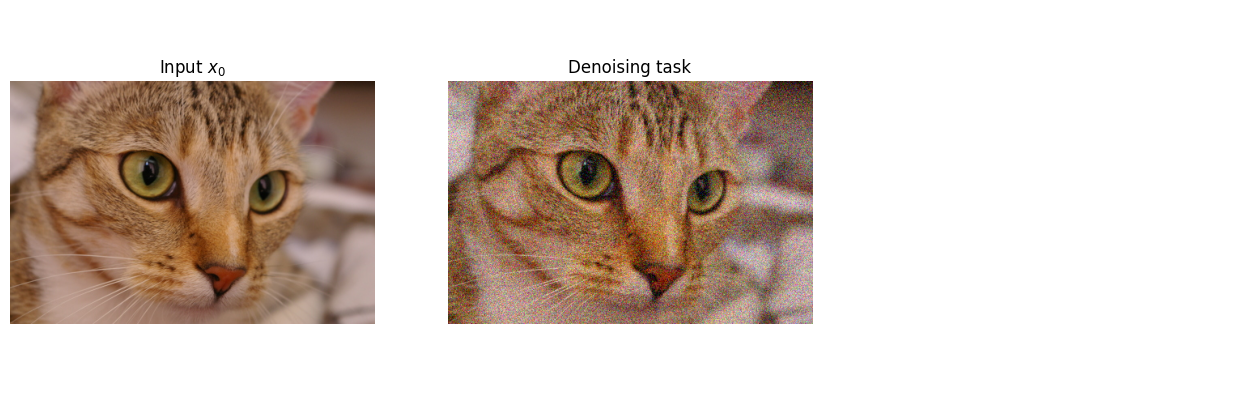

In [18]:
from skimage import data
from matplotlib import pyplot as plt 

img = data.chelsea().astype(np.float32) / 255.

_, axis = plt.subplots(1, 3, figsize=(16, 5))
axis[0].imshow(img); axis[0].set_title("Input $x_0$")
axis[1].imshow(get_noisy_img(img)); axis[1].set_title("Denoising task")
for ax in axis:
    ax.set_axis_off()
plt.show()

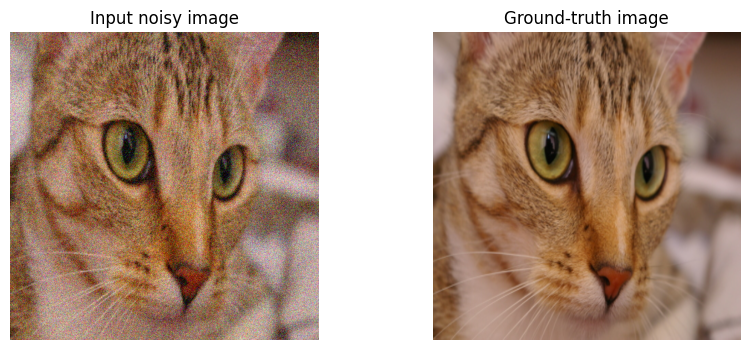

In [19]:
x_true = resize(data.chelsea().astype(np.float32) / 255., (512, 512))
x0 = get_noisy_img(x_true)
_, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(x0); axes[0].set_axis_off()
axes[0].set_title("Input noisy image")
axes[1].imshow(x_true); axes[1].set_axis_off()
axes[1].set_title("Ground-truth image")
plt.show()

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


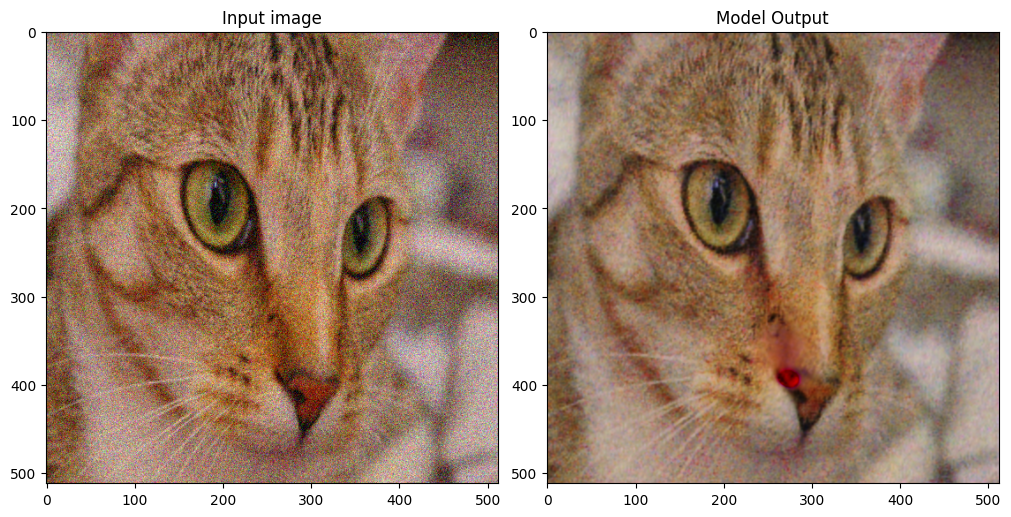

In [20]:
input_shape = x0.shape

model = deep_image_prior(input_shape)
x = dip_workflow(x0, model, input_shape, num_iters=2000)

In [21]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the .tiff file
file_path = '/kaggle/input/singleoctimg/RawDataQA1 (1).tiff'
image = Image.open(file_path)

# Convert the image to RGB (if necessary)
image = image.convert('RGB')

# Resize the image to the desired input shape (example shape: 128x128)
input_shape = (128, 128)
image = image.resize(input_shape)

# Convert the image to a NumPy array
image_array = np.array(image)

# Normalize the image array (assuming the model expects pixel values in [0, 1])
image_array = image_array / 255.0

# Now image_array is ready to be passed to a Keras model
# Example of model prediction
# model = ... # Load or define your Keras model
# prediction = model.predict(image_array)

print(image_array.shape)  # Should print (1, 128, 128, 3)

(128, 128, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


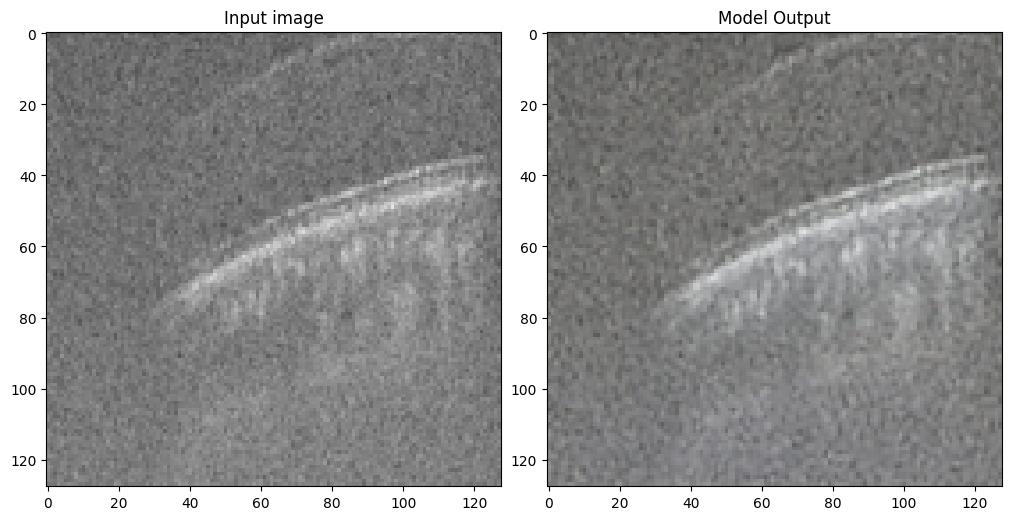

In [22]:
input_shape = image_array.shape

model = deep_image_prior(input_shape)
x = dip_workflow(image_array, model, input_shape, num_iters=3500)